In [98]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import xgboost as xgb
import lightgbm as lgb

In [5]:
# Load the dataset
df = pd.read_csv('/content/Bank.csv')

In [6]:
# 3. Exploratory Data Analysis (EDA)

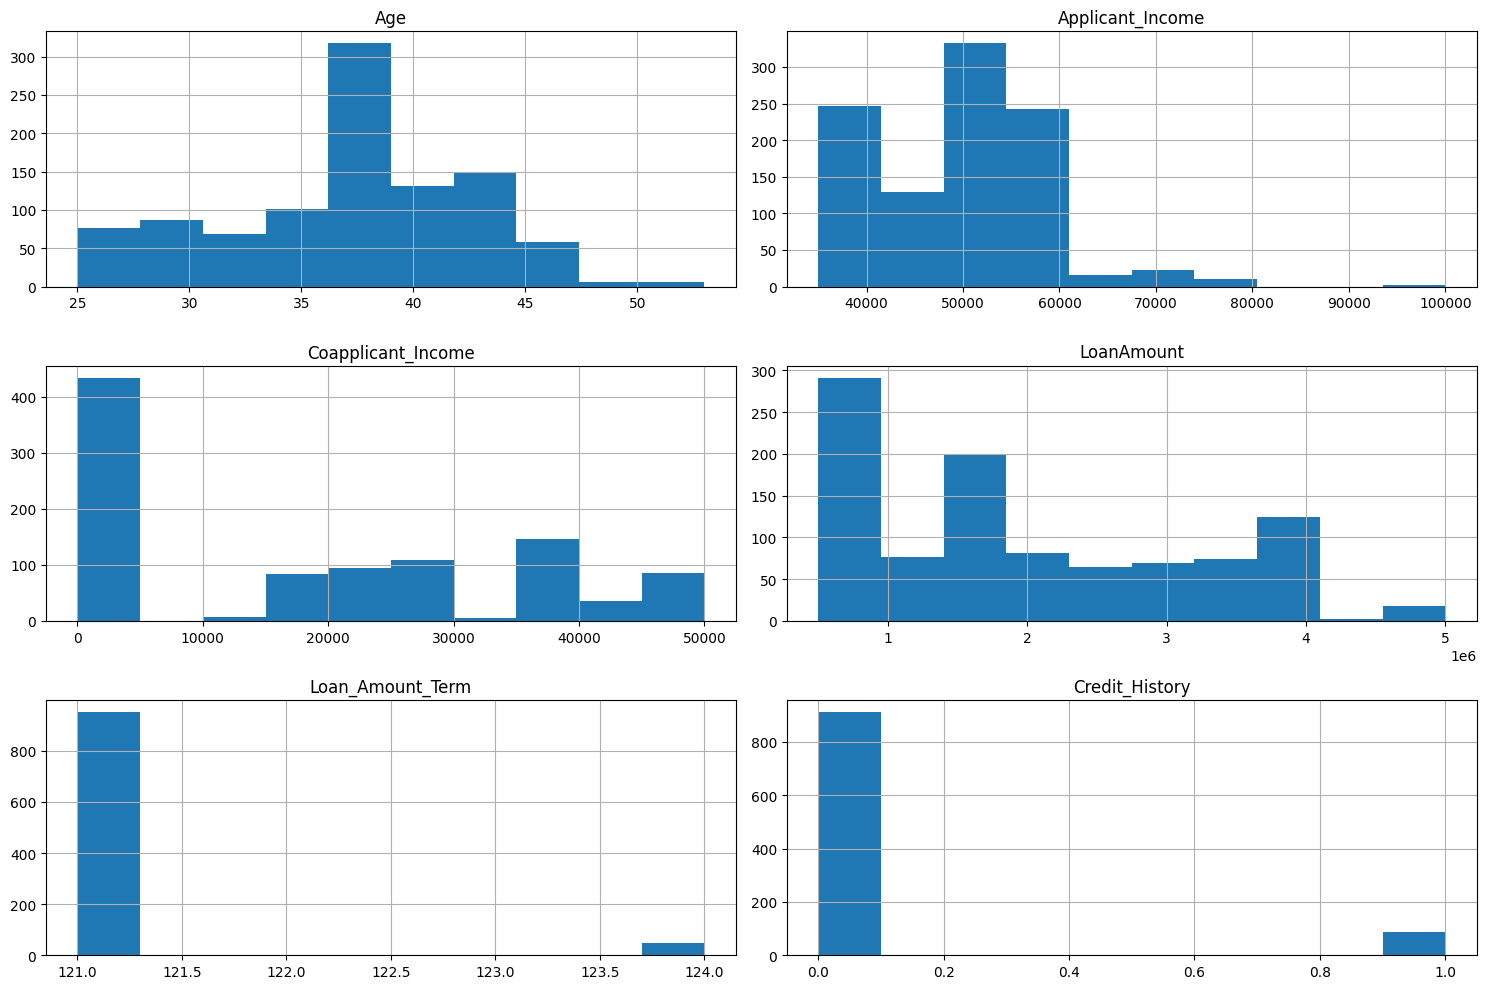

In [18]:
# i. Histograms for numerical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_features].hist(figsize=(15, 10))
plt.tight_layout()
plt.savefig('histograms.png')
plt.show()
plt.close()

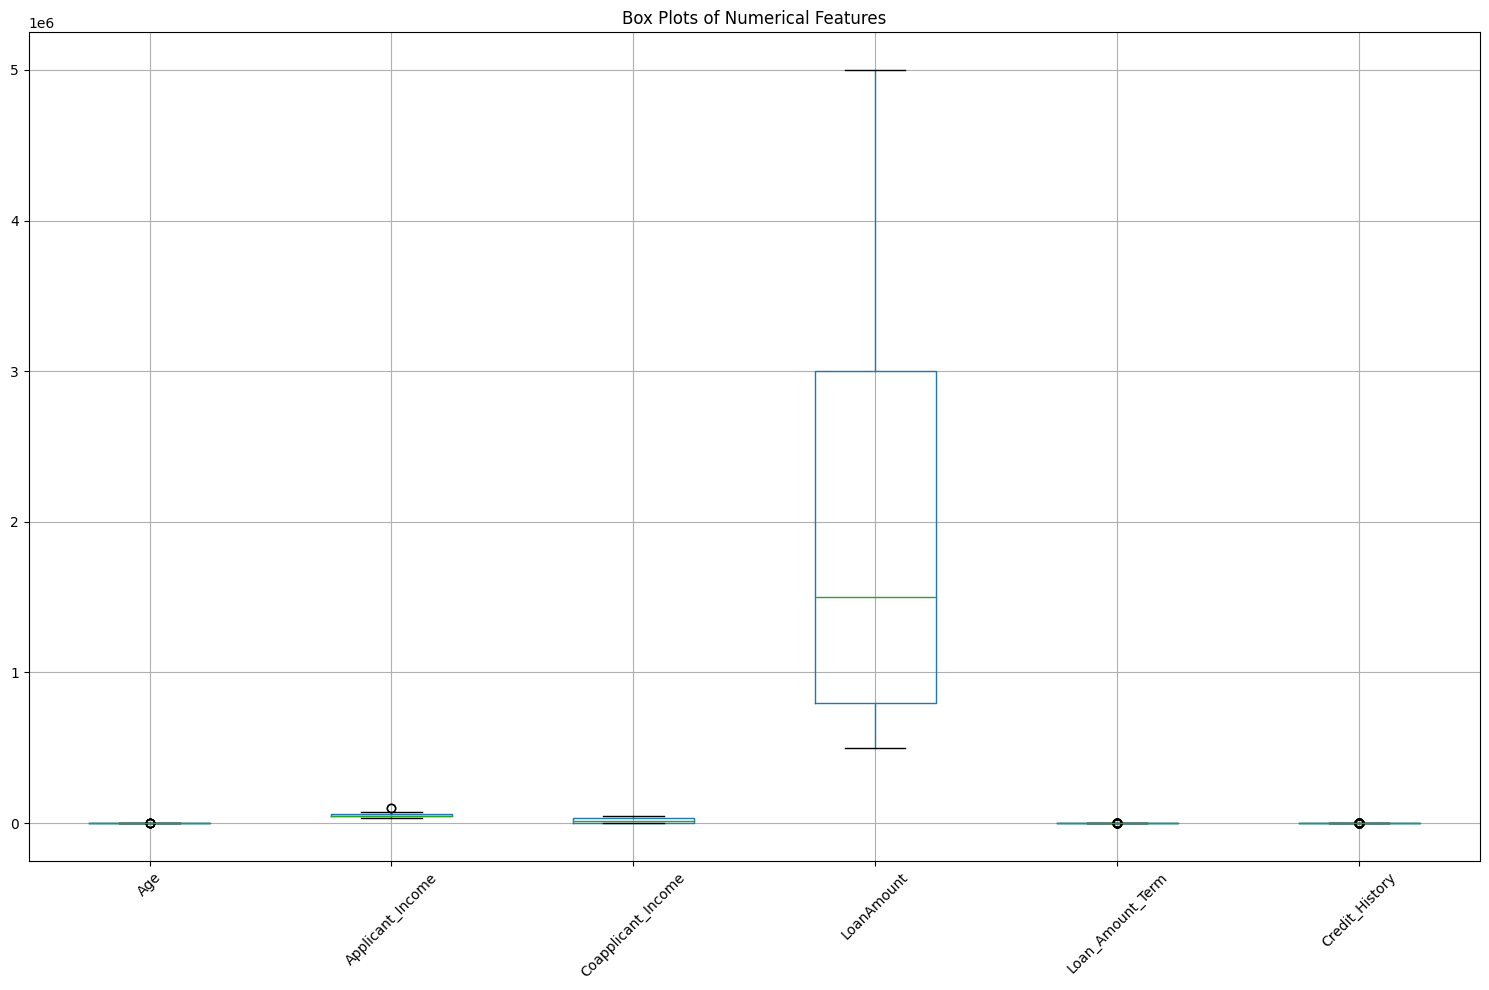

In [19]:
# ii. Box plots for numerical features
plt.figure(figsize=(15, 10))
df[numeric_features].boxplot()
plt.title('Box Plots of Numerical Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('boxplots.png')
plt.show()
plt.close()

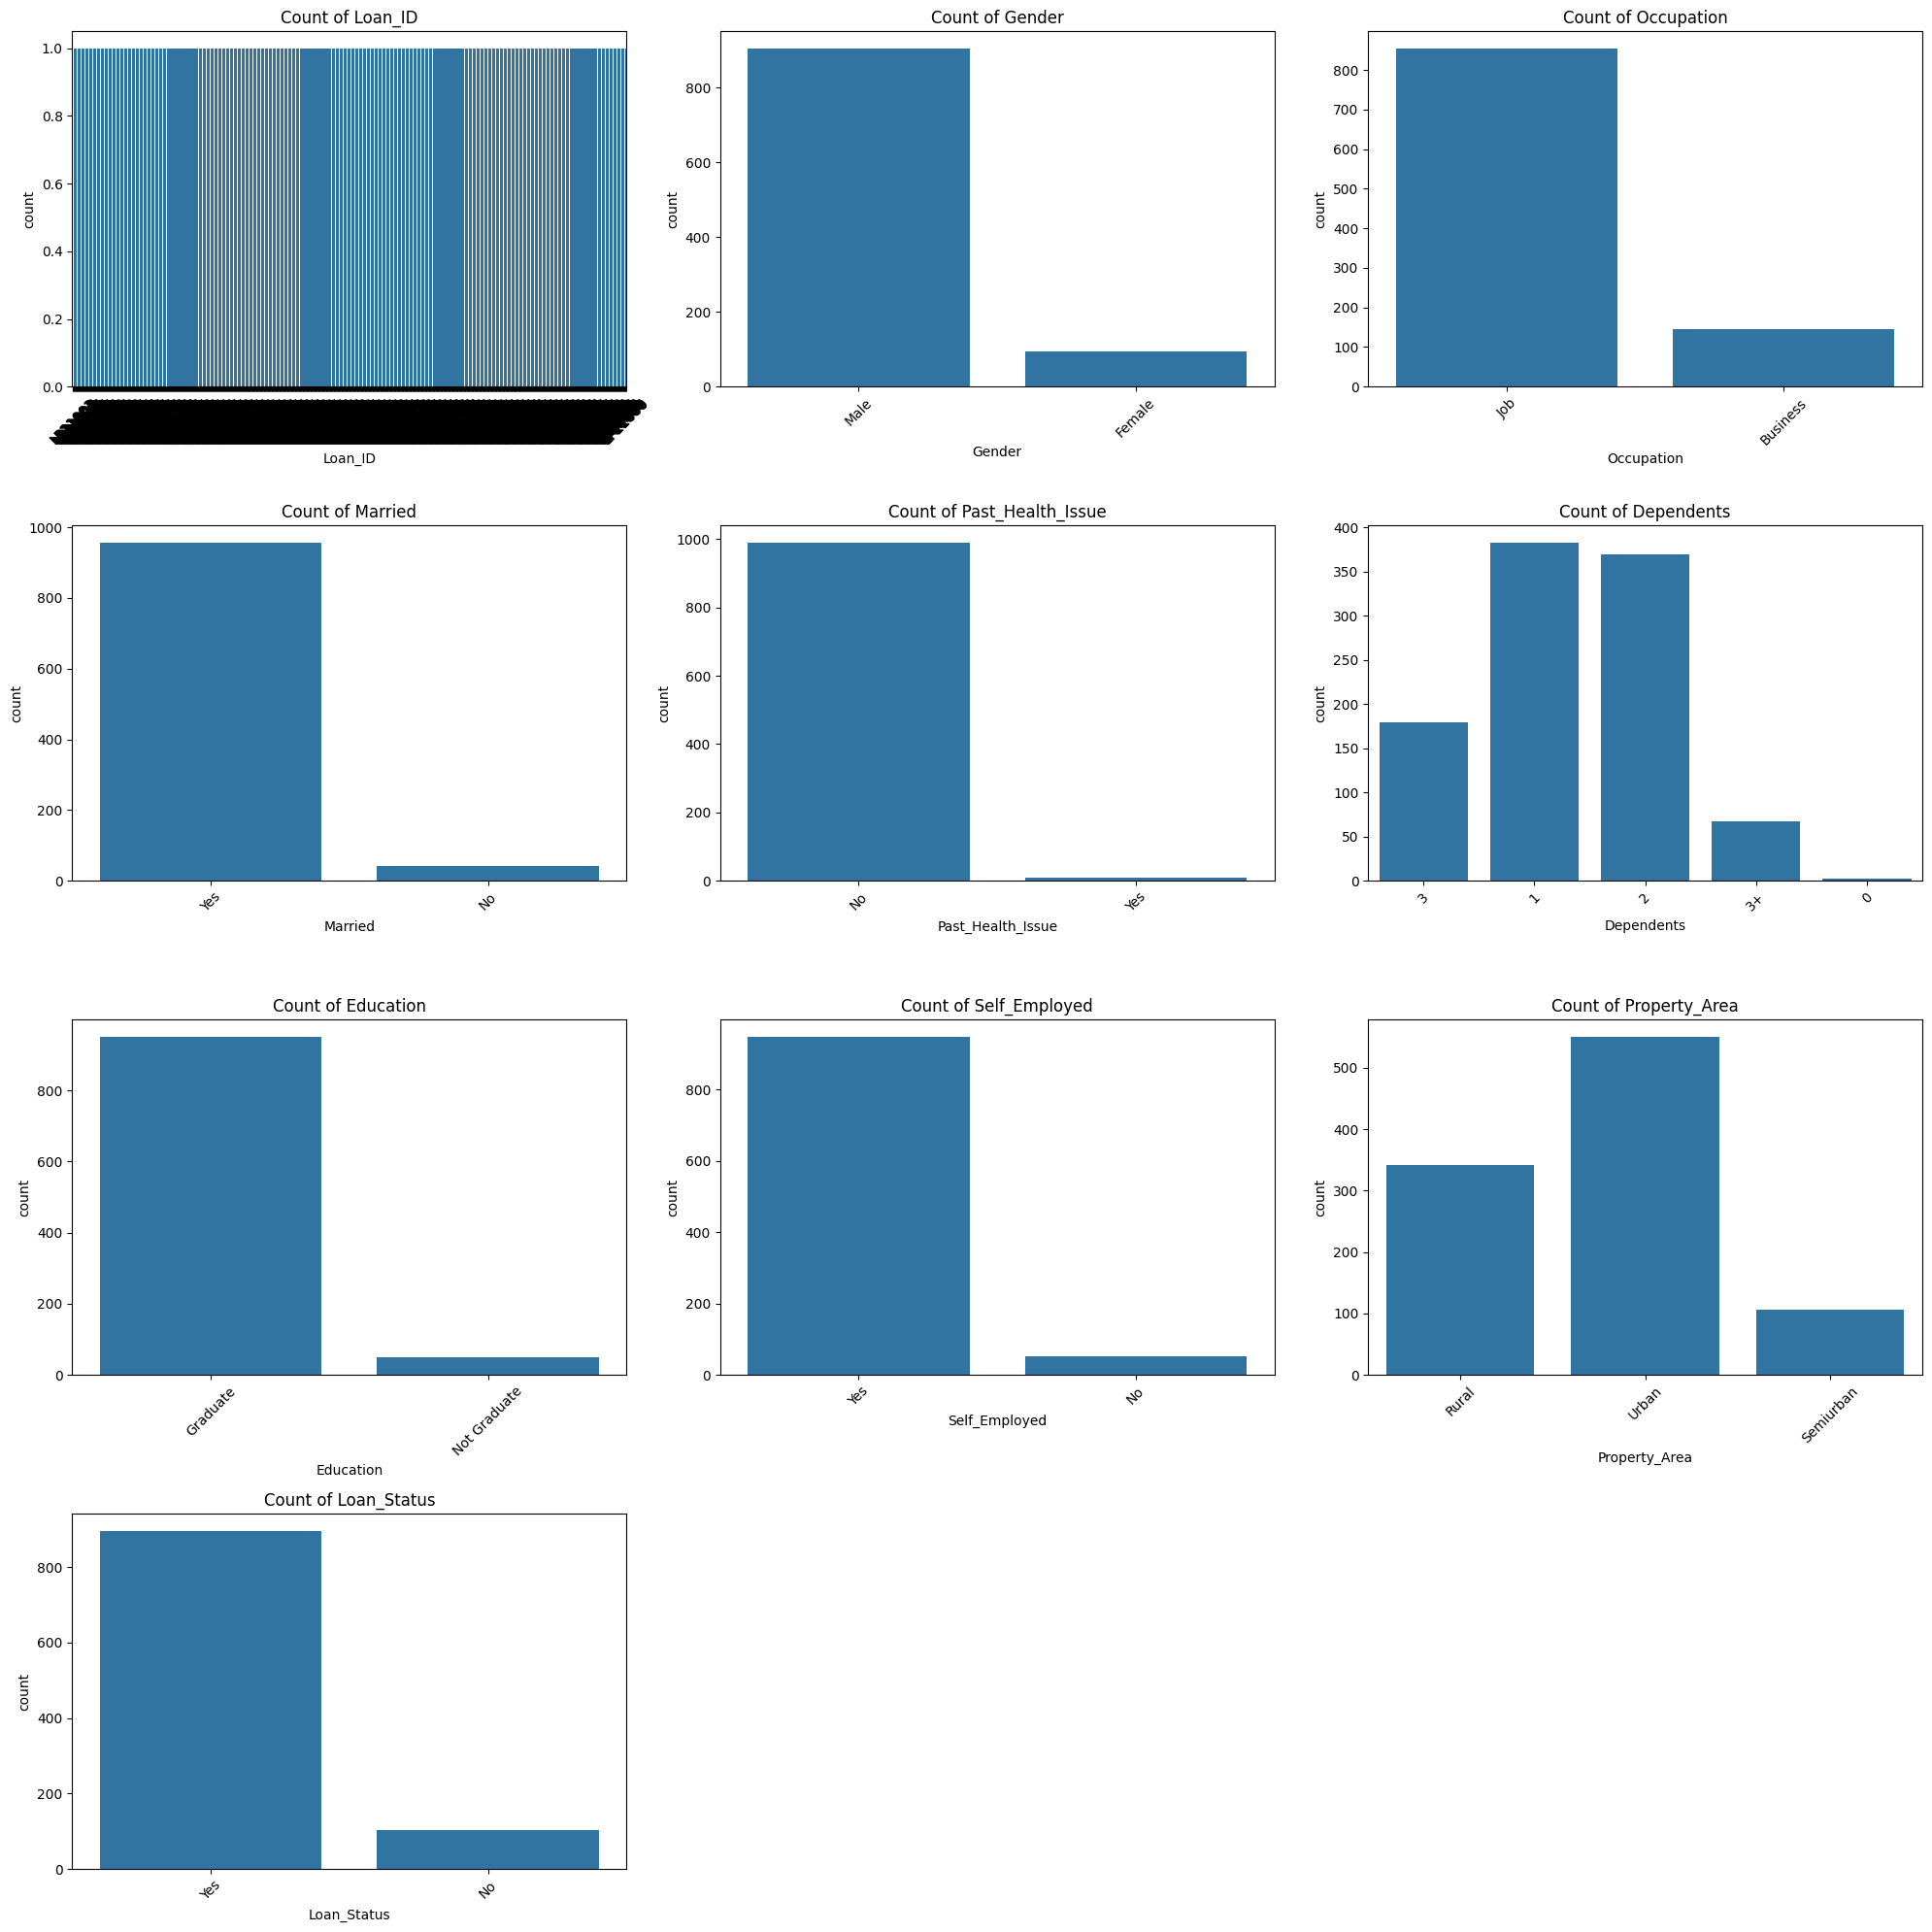

In [20]:
# iii. Bar plots for categorical features
categorical_features = df.select_dtypes(include=['object']).columns
# Calculate the number of rows for subplots based on the number of features
nrows = (len(categorical_features) + 2) // 3  # Round up to the nearest multiple of 3
fig, axes = plt.subplots(nrows, 3, figsize=(20, 20))
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Count of {feature}')
    axes[i//3, i%3].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(len(categorical_features), nrows * 3):
    fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
plt.savefig('categorical_barplots.png')
plt.show()
plt.close()

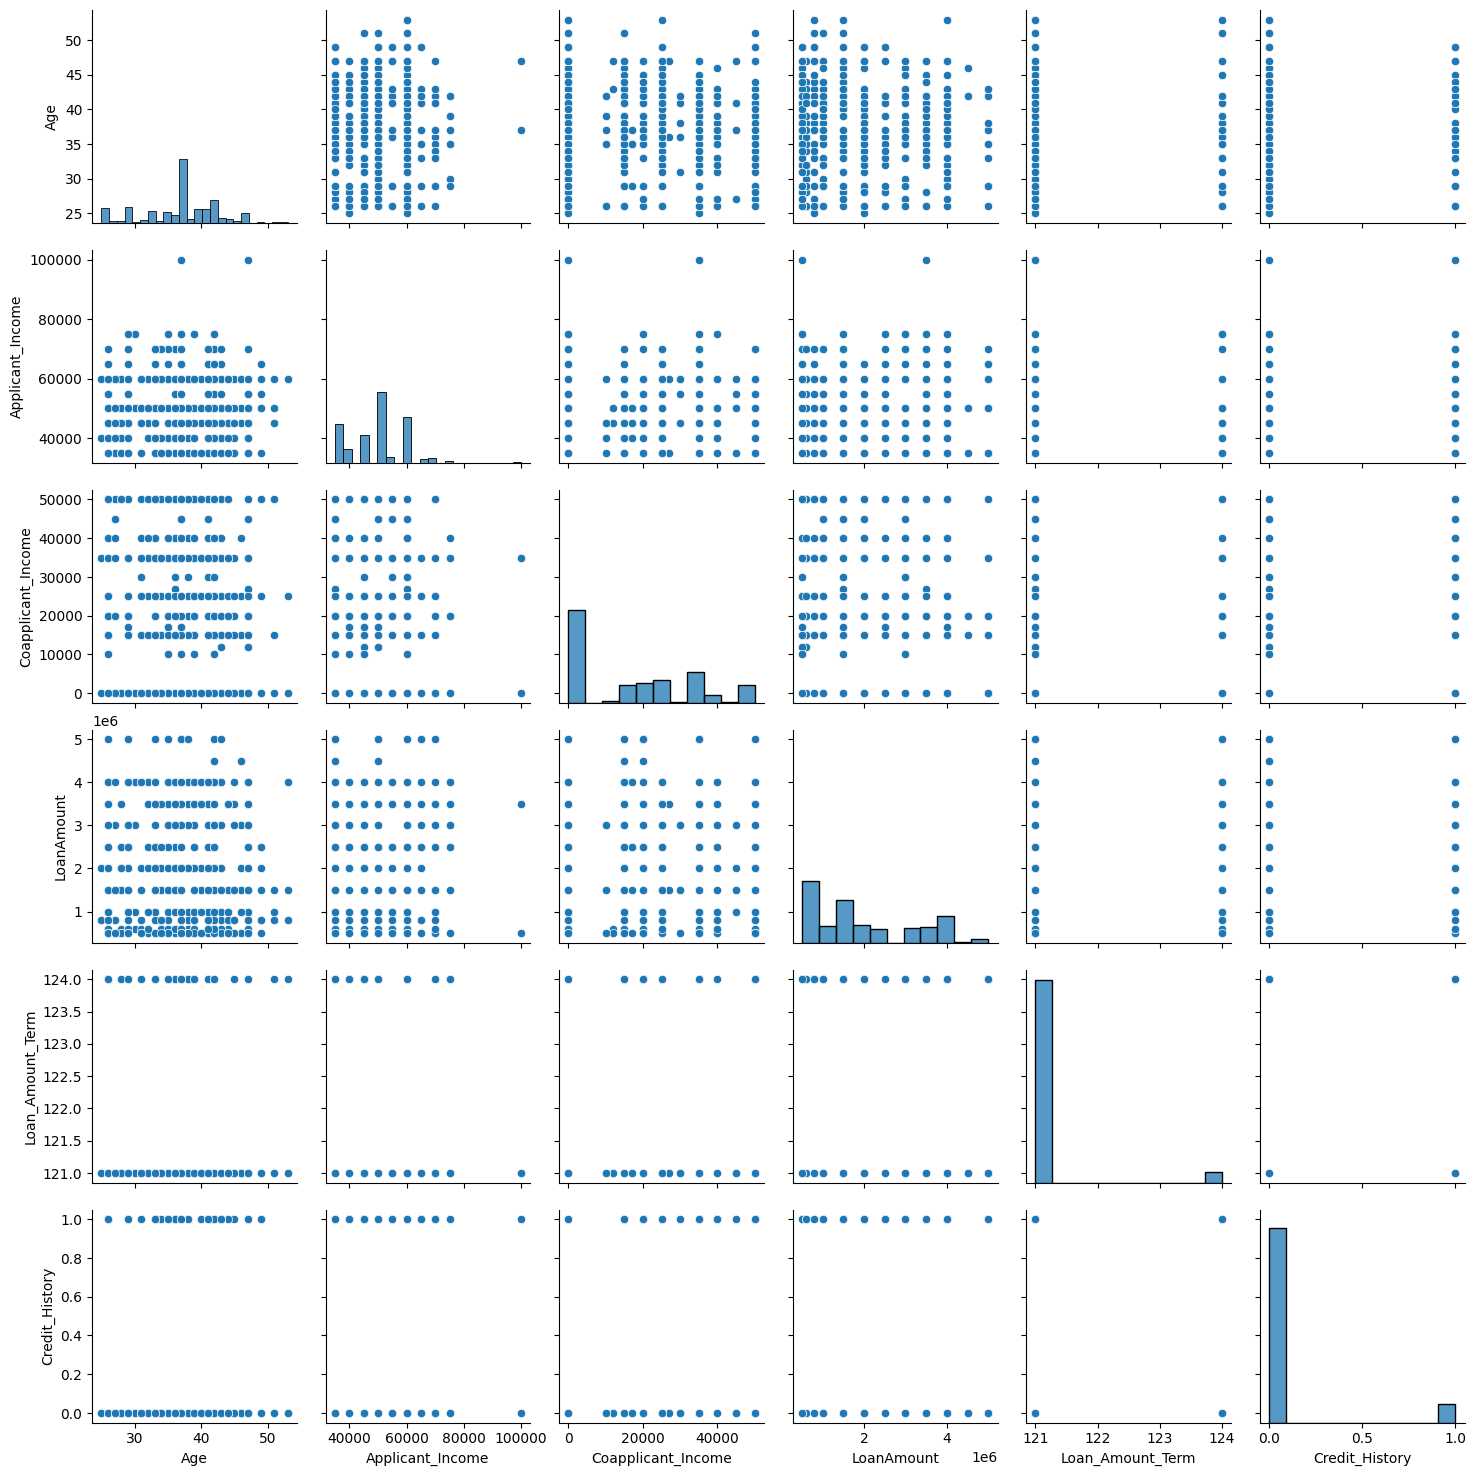

In [21]:
# iv. Pair plot for numerical features
sns.pairplot(df[numeric_features])
plt.savefig('pairplot.png')
plt.show()
plt.close()

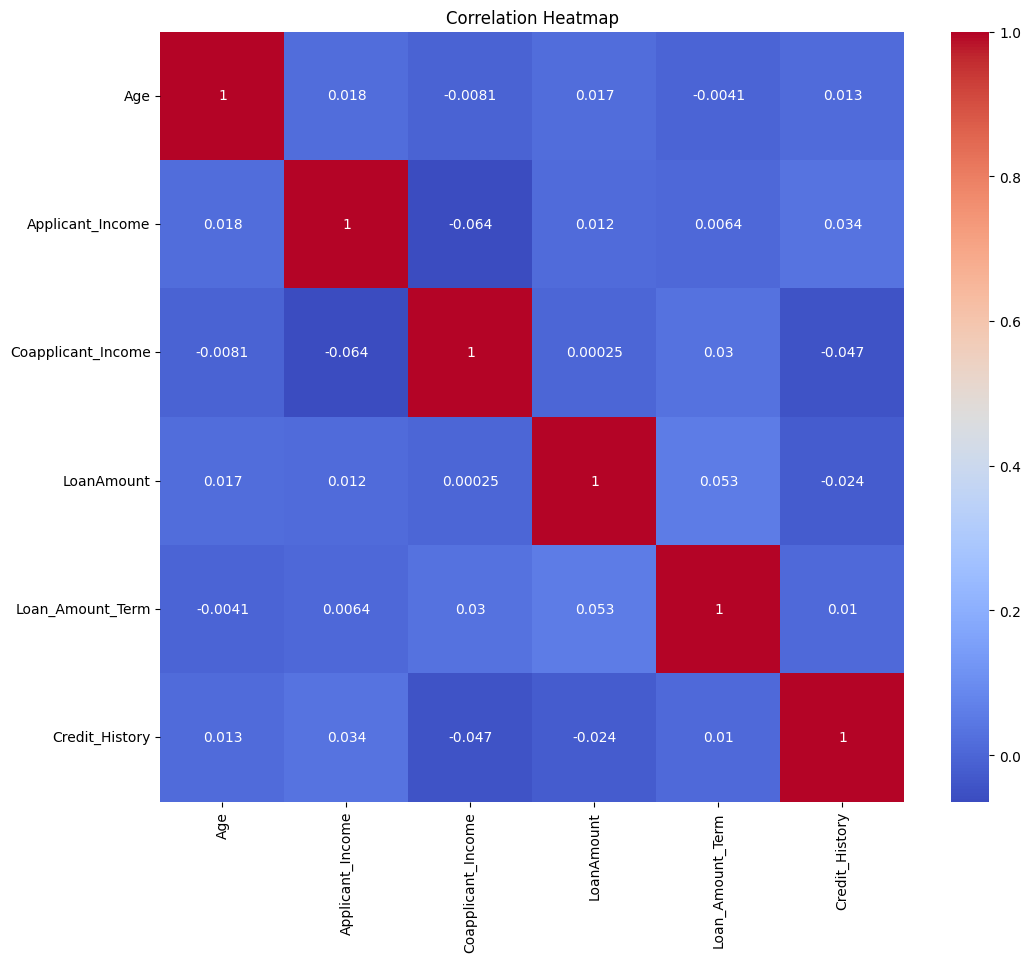

In [22]:
# v. Heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('heatmap.png')
plt.show()
plt.close()

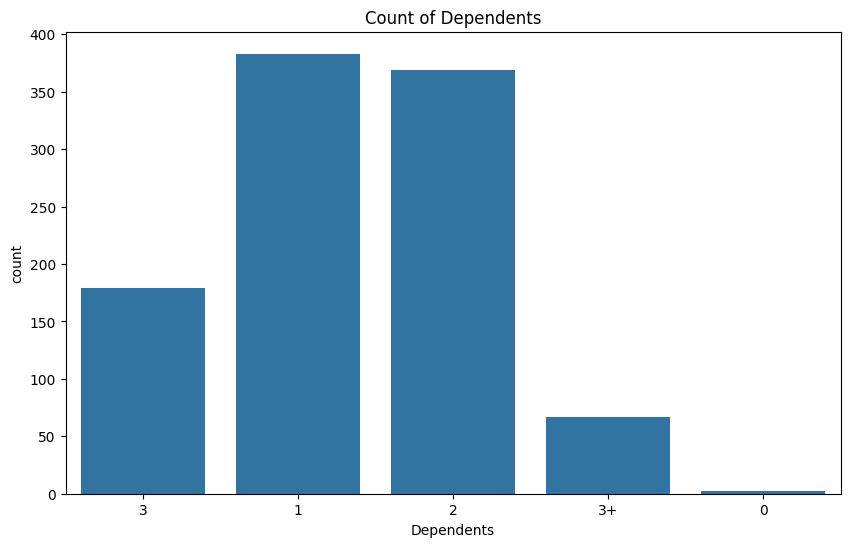

In [23]:
# vi. Count of dependents vs number of dependents
plt.figure(figsize=(10, 6))
sns.countplot(x='Dependents', data=df)
plt.title('Count of Dependents')
plt.savefig('dependents_count.png')
plt.show()
plt.close()

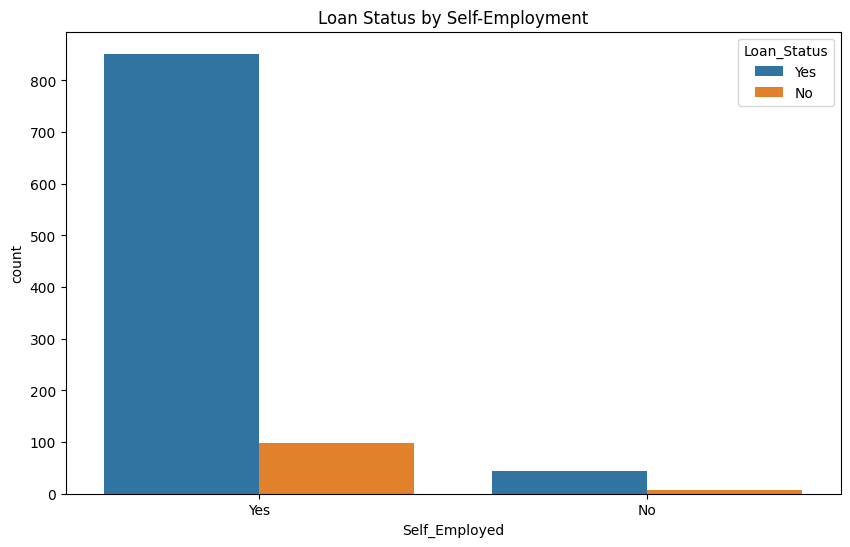

In [17]:
# vii. Loan status by self-employment
plt.figure(figsize=(10, 6))
sns.countplot(x='Self_Employed', hue='Loan_Status', data=df)
plt.title('Loan Status by Self-Employment')
plt.savefig('loan_status_by_self_employment.png')
plt.show()
plt.close()

In [24]:
# 4. Correlation Analysis

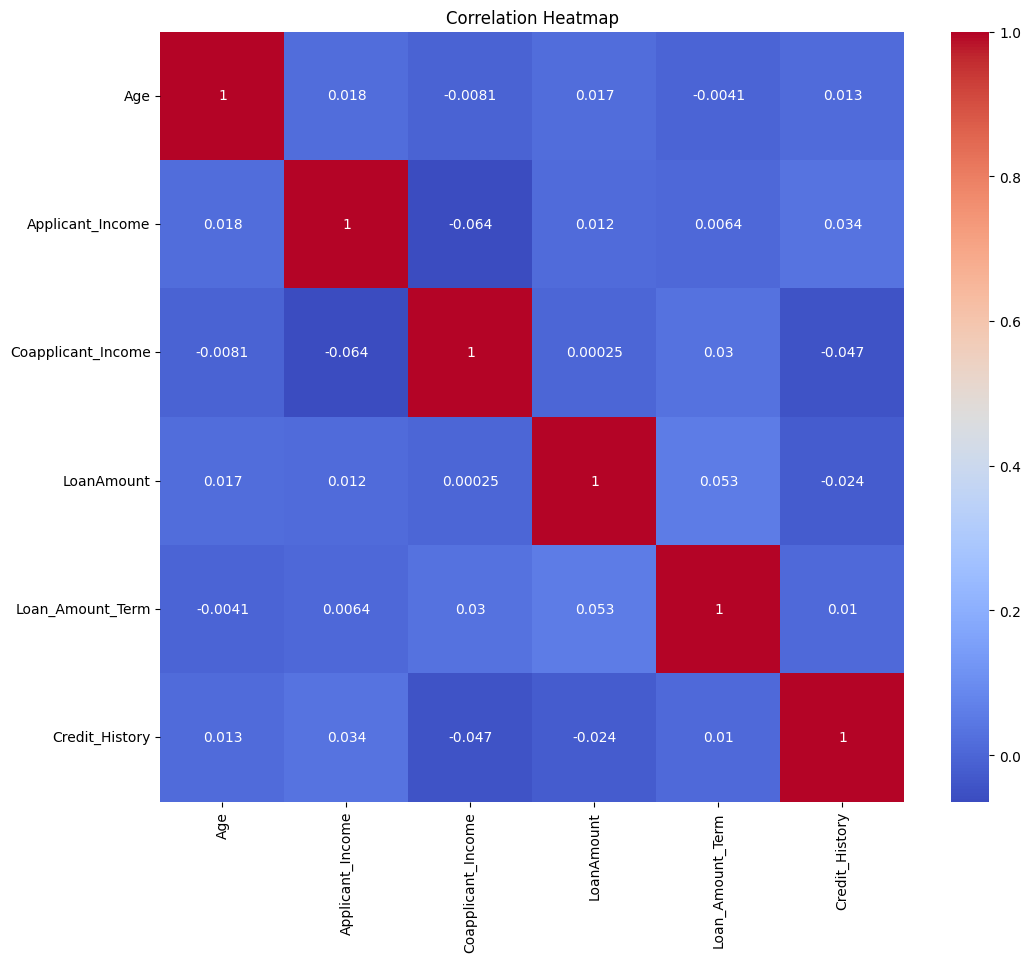

In [26]:
# i. Correlation matrix for numerical features
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [31]:
# ii. Chi-Square tests for categorical features
categorical_features = df.select_dtypes(include=['object']).columns
chi_square_results = {}
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Loan_Status'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[feature] = {'chi2_stat': chi2_stat, 'p_value': p_value}
    # Print the results
# Print the results
for feature, result in chi_square_results.items():
    print(f"Feature: {feature}")
    print(f"Chi-square statistic: {result['chi2_stat']:.2f}")
    print(f"P-value: {result['p_value']:.3f}")
    print("-" * 20)

Feature: Loan_ID
Chi-square statistic: 1000.00
P-value: 0.485
--------------------
Feature: Gender
Chi-square statistic: 0.05
P-value: 0.827
--------------------
Feature: Occupation
Chi-square statistic: 0.03
P-value: 0.865
--------------------
Feature: Married
Chi-square statistic: 2.39
P-value: 0.122
--------------------
Feature: Past_Health_Issue
Chi-square statistic: 77.58
P-value: 0.000
--------------------
Feature: Dependents
Chi-square statistic: 1.93
P-value: 0.749
--------------------
Feature: Education
Chi-square statistic: 0.59
P-value: 0.444
--------------------
Feature: Self_Employed
Chi-square statistic: 0.32
P-value: 0.573
--------------------
Feature: Property_Area
Chi-square statistic: 0.19
P-value: 0.908
--------------------
Feature: Loan_Status
Chi-square statistic: 989.30
P-value: 0.000
--------------------


In [47]:
# 5. Data Preprocessing

In [48]:
# Prepare the target variable
y = df['Loan_Status'].map({'Yes': 1, 'No': 0})
X = df.drop('Loan_Status', axis=1)

In [50]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = df.loc[X_train.index]
X_test = df.loc[X_test.index]

In [51]:
# Define categorical and numerical columns (excluding 'Loan_Status')
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

In [55]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [56]:
# Function to evaluate models (unchanged)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except:
        auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, f1, auc, cm

In [57]:
# 7.1 Machine Learning Models
ml_models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

ml_results = {}

for name, model in ml_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)  # Now fit on data with 'Loan_Status'
    accuracy, f1, auc, cm = evaluate_model(pipeline, X_test, y_test)
    ml_results[name] = {'accuracy': accuracy, 'f1': f1, 'auc': auc, 'cm': cm}
    print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

Logistic Regression - Accuracy: 0.9300, F1: 0.9609, AUC: 0.8170
Confusion Matrix:
[[ 14   7]
 [  7 172]]

Decision Tree - Accuracy: 0.9200, F1: 0.9558, AUC: 0.7451
Confusion Matrix:
[[ 11  10]
 [  6 173]]

SVM - Accuracy: 0.9350, F1: 0.9640, AUC: 0.7587
Confusion Matrix:
[[ 13   8]
 [  5 174]]

KNN - Accuracy: 0.9300, F1: 0.9611, AUC: 0.8132
Confusion Matrix:
[[ 13   8]
 [  6 173]]



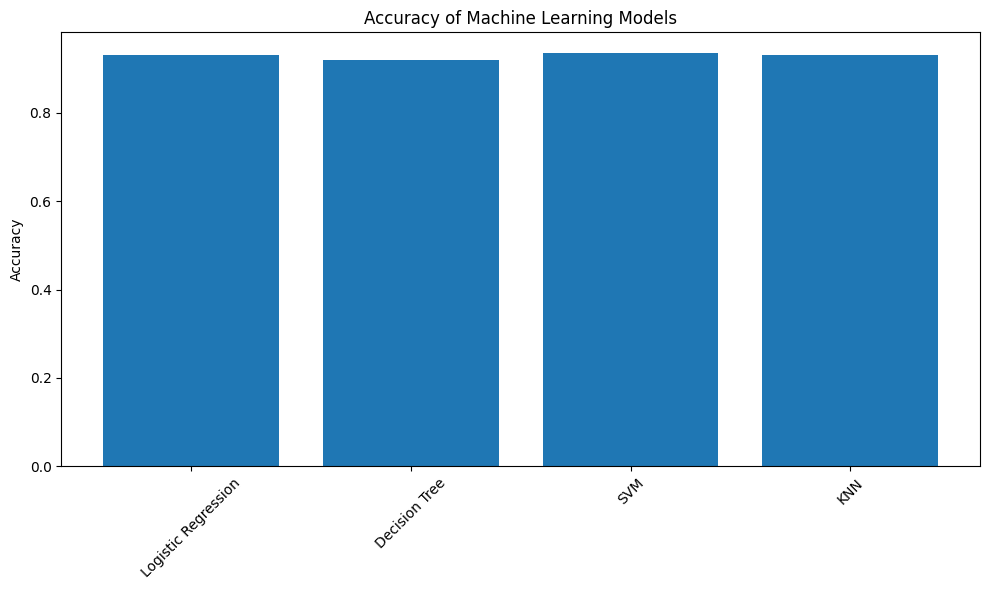

The model with the highest accuracy is: SVM with accuracy 0.9350


In [64]:
# Visualize ML model results
plt.figure(figsize=(10, 6))
plt.bar(ml_results.keys(), [result['accuracy'] for result in ml_results.values()])
plt.title('Accuracy of Machine Learning Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ml_model_accuracy.png')
plt.show()
plt.close()
best_model = max(ml_results, key=lambda k: ml_results[k]['accuracy'])
print(f"The model with the highest accuracy is: {best_model} with accuracy {ml_results[best_model]['accuracy']:.4f}")

In [69]:
# 7.2 Deep Learning Models

# a. Artificial Neural Network (ANN)
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(preprocessor.fit_transform(X_train).toarray().shape[1],)),  # Dynamically set input shape
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(preprocessor.fit_transform(X_train).toarray(), y_train, epochs=10, batch_size=32, validation_split=0.2)
# b. Long Short-Term Memory Network (LSTM)
lstm_model = Sequential([
    LSTM(64, input_shape=(preprocessor.fit_transform(X_train).toarray().shape[1], 1)), # Set input shape based on preprocessor output
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(preprocessor.fit_transform(X_train).toarray().reshape(preprocessor.fit_transform(X_train).toarray().shape[0], preprocessor.fit_transform(X_train).toarray().shape[1], 1),
              y_train, epochs=10, batch_size=32, validation_split=0.2) # Reshape the preprocessed data

# c. Gated Recurrent Unit (GRU)
gru_model = Sequential([
    GRU(64, input_shape=(preprocessor.fit_transform(X_train).toarray().shape[1], 1)), # Set input shape based on preprocessor output
    Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.fit(preprocessor.fit_transform(X_train).toarray().reshape(preprocessor.fit_transform(X_train).toarray().shape[0], preprocessor.fit_transform(X_train).toarray().shape[1], 1),
              y_train, epochs=10, batch_size=32, validation_split=0.2) # Reshape the preprocessed data

Epoch 1/10
20/20 [==============================] - 1s 18ms/step - loss: 0.5145 - accuracy: 0.8828 - val_loss: 0.3531 - val_accuracy: 0.9000
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.2963 - accuracy: 0.8953 - val_loss: 0.2536 - val_accuracy: 0.9000
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.2274 - accuracy: 0.9000 - val_loss: 0.2190 - val_accuracy: 0.9125
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1934 - accuracy: 0.9438 - val_loss: 0.2079 - val_accuracy: 0.9375
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.1762 - accuracy: 0.9500 - val_loss: 0.2044 - val_accuracy: 0.9375
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.1657 - accuracy: 0.9500 - val_loss: 0.2059 - val_accuracy: 0.9375
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1539 - accuracy: 0.9500 - val_loss: 0.2055 - val_accuracy: 0.9375
Epoch 8/10
20/20 [=

In [70]:
# Evaluate Deep Learning Models
dl_models = {
    'ANN': ann_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}

dl_results = {}

for name, model in dl_models.items():
    # Reshape data for LSTM and GRU models
    if name in ['LSTM', 'GRU']:
        X_test_reshaped = preprocessor.transform(X_test).toarray().reshape(preprocessor.transform(X_test).toarray().shape[0], preprocessor.transform(X_test).toarray().shape[1], 1)
        y_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)
    else:
        y_pred = (model.predict(preprocessor.transform(X_test)) > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Reshape data for AUC calculation for LSTM and GRU
    if name in ['LSTM', 'GRU']:
        auc = roc_auc_score(y_test, model.predict(X_test_reshaped))
    else:
        auc = roc_auc_score(y_test, model.predict(preprocessor.transform(X_test)))

    cm = confusion_matrix(y_test, y_pred)
    dl_results[name] = {'accuracy': accuracy, 'f1': f1, 'auc': auc, 'cm': cm}

    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")

7/7 [==============================] - 0s 3ms/step
--- ANN ---
Accuracy: 0.9300
F1 Score: 0.9609
ROC-AUC: 0.8646
Confusion Matrix:
[[ 14   7]
 [  7 172]]


7/7 [==============================] - 1s 146ms/step
--- LSTM ---
Accuracy: 0.8950
F1 Score: 0.9446
ROC-AUC: 0.5270
Confusion Matrix:
[[  0  21]
 [  0 179]]


7/7 [==============================] - 0s 66ms/step
--- GRU ---
Accuracy: 0.8950
F1 Score: 0.9446
ROC-AUC: 0.4859
Confusion Matrix:
[[  0  21]
 [  0 179]]




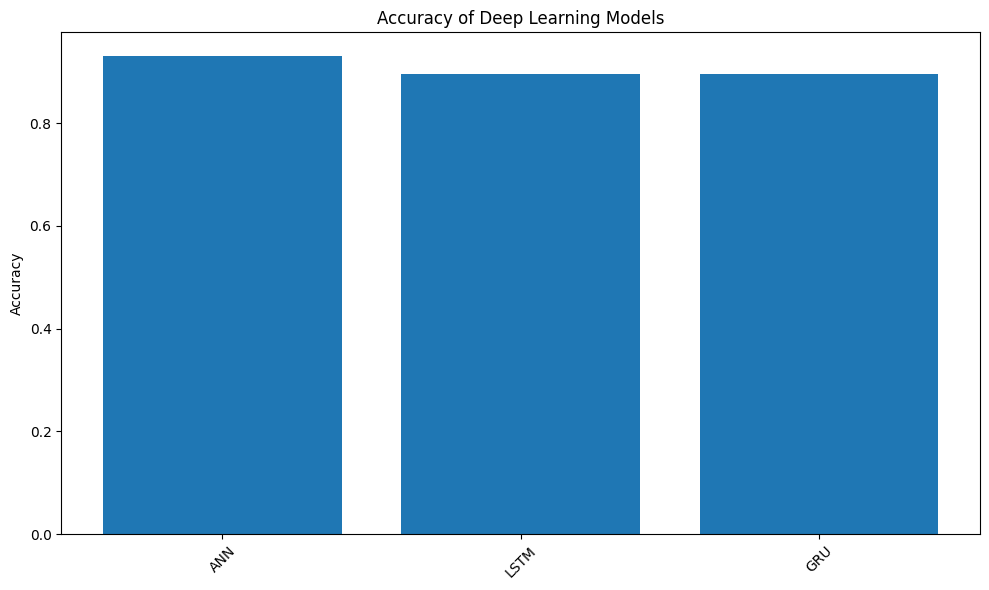

The Deep Learning model with the highest accuracy is: ANN with accuracy 0.9300


In [71]:
# Visualize DL model results (Bar Graph)
plt.figure(figsize=(10, 6))
plt.bar(dl_results.keys(), [result['accuracy'] for result in dl_results.values()])
plt.title('Accuracy of Deep Learning Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('dl_model_accuracy.png')
plt.show()
plt.close()
# Identify the best DL model
best_dl_model = max(dl_results, key=lambda k: dl_results[k]['accuracy'])
print(f"The Deep Learning model with the highest accuracy is: {best_dl_model} with accuracy {dl_results[best_dl_model]['accuracy']:.4f}")

In [73]:
# 7.3 Ensemble Methods
# a. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(preprocessor.fit_transform(X_train).toarray(), y_train)
rf_accuracy, rf_f1, rf_auc, rf_cm = evaluate_model(rf_model, preprocessor.transform(X_test).toarray(), y_test)

# b. XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(preprocessor.fit_transform(X_train).toarray(), y_train)
xgb_accuracy, xgb_f1, xgb_auc, xgb_cm = evaluate_model(xgb_model, preprocessor.transform(X_test).toarray(), y_test)

# c. LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(preprocessor.fit_transform(X_train).toarray(), y_train)
lgb_accuracy, lgb_f1, lgb_auc, lgb_cm = evaluate_model(lgb_model, preprocessor.transform(X_test).toarray(), y_test)

# d. Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(preprocessor.fit_transform(X_train).toarray(), y_train)
gb_accuracy, gb_f1, gb_auc, gb_cm = evaluate_model(gb_model, preprocessor.transform(X_test).toarray(), y_test)


print(f"Confusion Matrix:\n{xgb_cm}\n")
print(f"LightGBM - Accuracy: {lgb_accuracy:.4f}, F1: {lgb_f1:.4f}, AUC: {lgb_auc:.4f}")
print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, F1: {rf_f1:.4f}, AUC: {rf_auc:.4f}")
print(f"Confusion Matrix:\n{rf_cm}\n")
print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, F1: {xgb_f1:.4f}, AUC: {xgb_auc:.4f}")
print(f"Confusion Matrix:\n{lgb_cm}\n")
print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}, F1: {gb_f1:.4f}, AUC: {gb_auc:.4f}")
print(f"Confusion Matrix:\n{gb_cm}\n")

[LightGBM] [Info] Number of positive: 717, number of negative: 83
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.896250 -> initscore=2.156235
[LightGBM] [Info] Start training from score 2.156235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

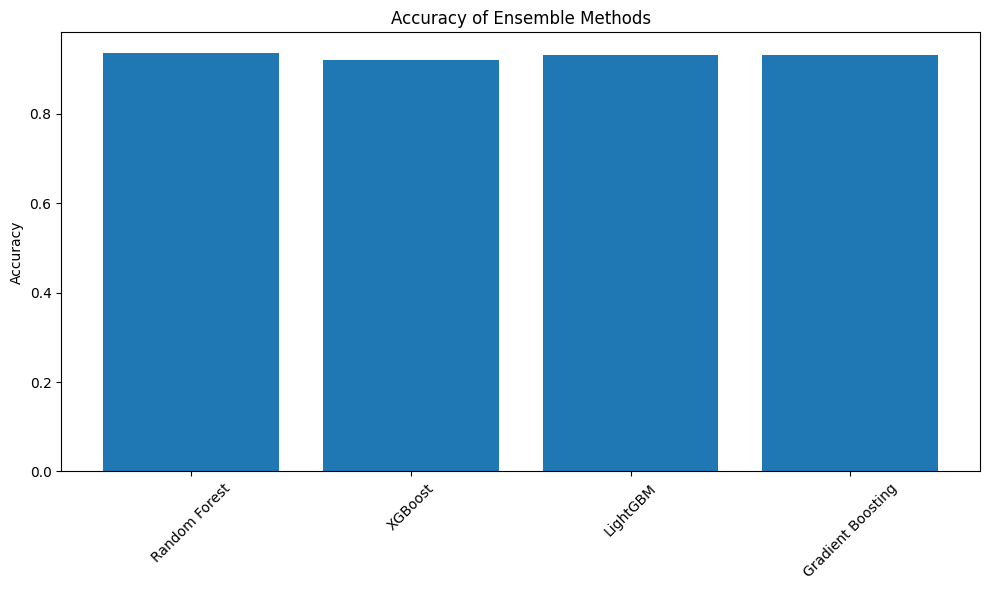

The Ensemble Method model with the highest accuracy is: Random Forest with accuracy 0.9350


In [75]:
# Store ensemble method results
ensemble_results = {
    'Random Forest': {'accuracy': rf_accuracy},
    'XGBoost': {'accuracy': xgb_accuracy},
    'LightGBM': {'accuracy': lgb_accuracy},
    'Gradient Boosting': {'accuracy': gb_accuracy}
}

# iii. Create a bar graph comparing the accuracy of 7.3 Ensemble Methods models
plt.figure(figsize=(10, 6))
plt.bar(ensemble_results.keys(), [result['accuracy'] for result in ensemble_results.values()])
plt.title('Accuracy of Ensemble Methods')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# iv. Identify the highest accuracy Ensemble Method model
best_ensemble_model = max(ensemble_results, key=lambda k: ensemble_results[k]['accuracy'])
print(f"The Ensemble Method model with the highest accuracy is: {best_ensemble_model} with accuracy {ensemble_results[best_ensemble_model]['accuracy']:.4f}")

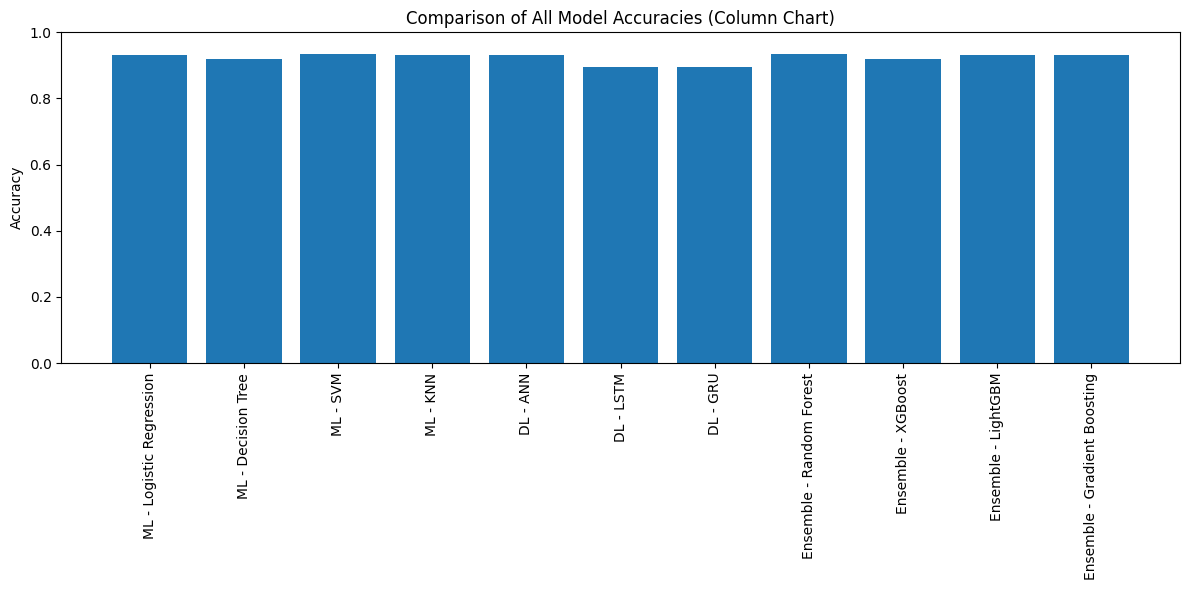

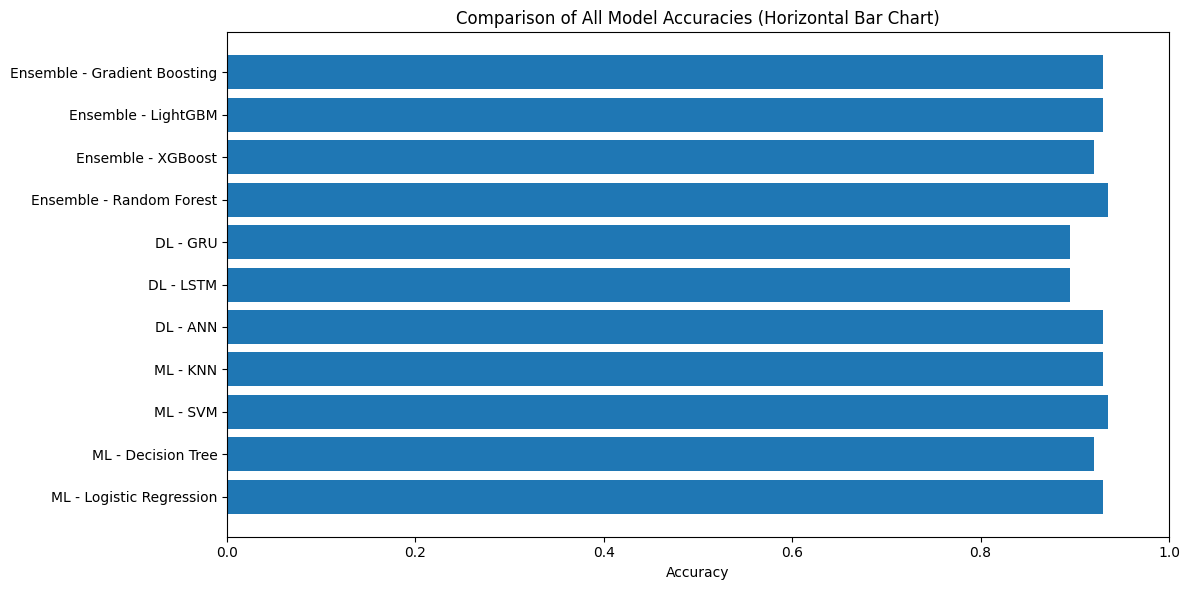

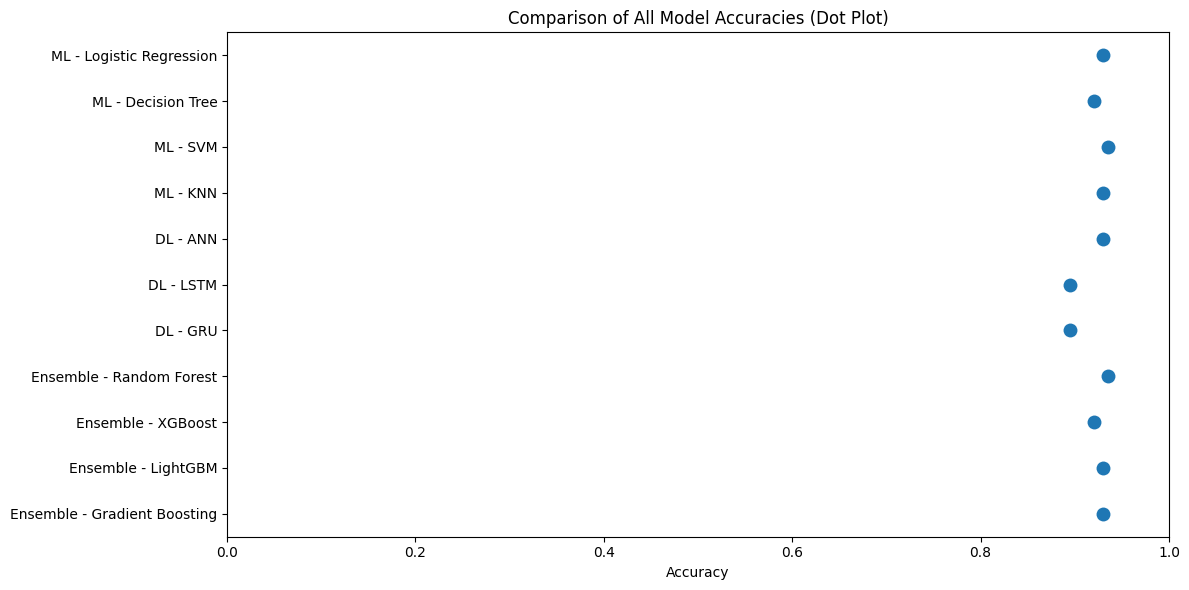

The best overall model is: ML - SVM with accuracy 0.9350


In [78]:
# Collect accuracies of all models (same as previous response)
all_model_accuracies = {
    **{f'ML - {model}': results['accuracy'] for model, results in ml_results.items()},
    **{f'DL - {model}': results['accuracy'] for model, results in dl_results.items()},
    **{f'Ensemble - {model}': results['accuracy'] for model, results in ensemble_results.items()}
}

# 1. Column Bar Chart (Vertical)
plt.figure(figsize=(12, 6))
plt.bar(all_model_accuracies.keys(), all_model_accuracies.values())
plt.title('Comparison of All Model Accuracies (Column Chart)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Horizontal Bar Chart
plt.figure(figsize=(12, 6))
plt.barh(list(all_model_accuracies.keys()), list(all_model_accuracies.values()))
plt.title('Comparison of All Model Accuracies (Horizontal Bar Chart)')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# 3. Dot Plot / Strip Plot
plt.figure(figsize=(12, 6))
sns.stripplot(x=list(all_model_accuracies.values()), y=list(all_model_accuracies.keys()), size=10)
plt.title('Comparison of All Model Accuracies (Dot Plot)')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Identify the best overall model (same as previous response)
best_overall_model = max(all_model_accuracies, key=all_model_accuracies.get)
print(f"The best overall model is: {best_overall_model} with accuracy {all_model_accuracies[best_overall_model]:.4f}")

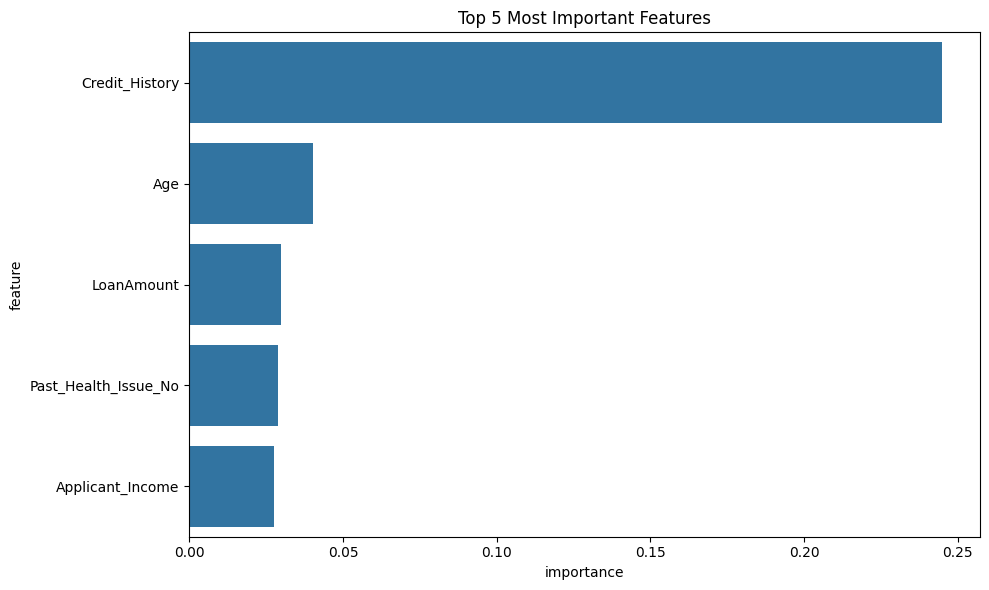

In [89]:
# 9. Feature Importance Analysis

# Using Random Forest for feature importance
rf_model = RandomForestClassifier()
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])
rf_pipeline.fit(X_train, y_train)

feature_names = (preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
                 preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())

importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(5))
plt.title('Top 5 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()
plt.close()

In [92]:
# 10. Loan Approval Probabilities Analysis

def analyze_approval_rates(feature):
    approval_rates = df.groupby(feature)['Loan_Status'].value_counts(normalize=True).unstack()
    approval_rates['Yes'].plot(kind='bar')
    plt.title(f'Loan Approval Rates by {feature}')
    plt.ylabel('Approval Rate')
    plt.tight_layout()
    plt.savefig(f'{feature.lower()}_approval_rates.png')
    plt.close()
    return approval_rates

gender_approval = analyze_approval_rates('Gender')
education_approval = analyze_approval_rates('Education')
employment_approval = analyze_approval_rates('Self_Employed')
print("\n3. Loan Approval Probabilities:")
print(f"   Gender: Male - {gender_approval['Yes']['Male']:.2f}, Female - {gender_approval['Yes']['Female']:.2f}")
print(f"   Education: Graduate - {education_approval['Yes']['Graduate']:.2f}, Not Graduate - {education_approval['Yes']['Not Graduate']:.2f}")
print(f"   Employment: Employed - {employment_approval['Yes']['Yes']:.2f}, Not Employed - {employment_approval['Yes']['No']:.2f}")


3. Loan Approval Probabilities:
   Gender: Male - 0.90, Female - 0.88
   Education: Graduate - 0.89, Not Graduate - 0.94
   Employment: Employed - 0.90, Not Employed - 0.86


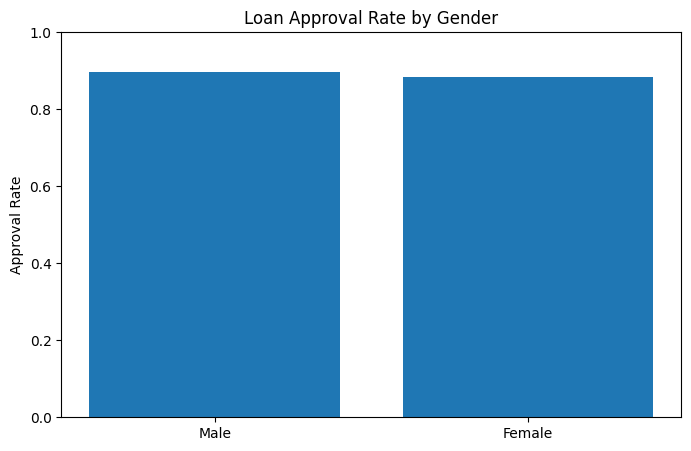

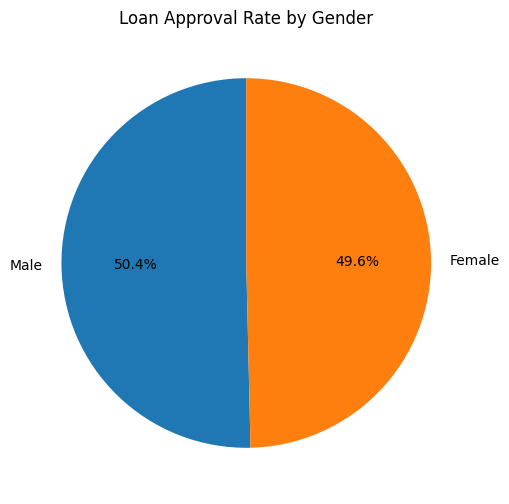

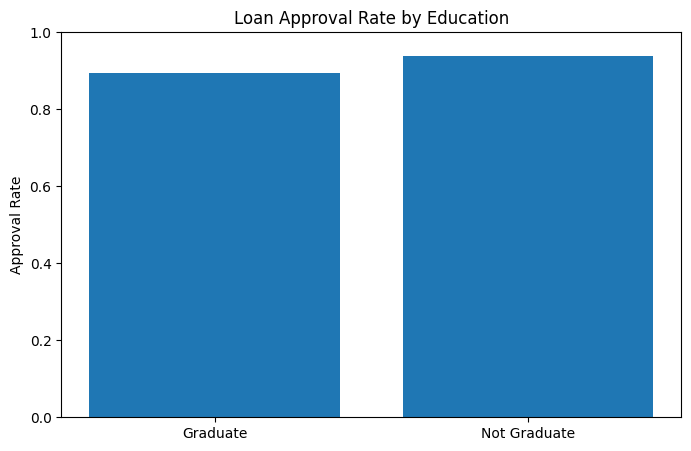

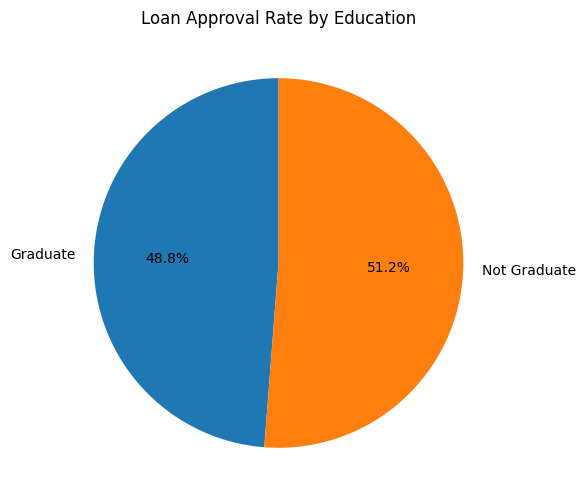

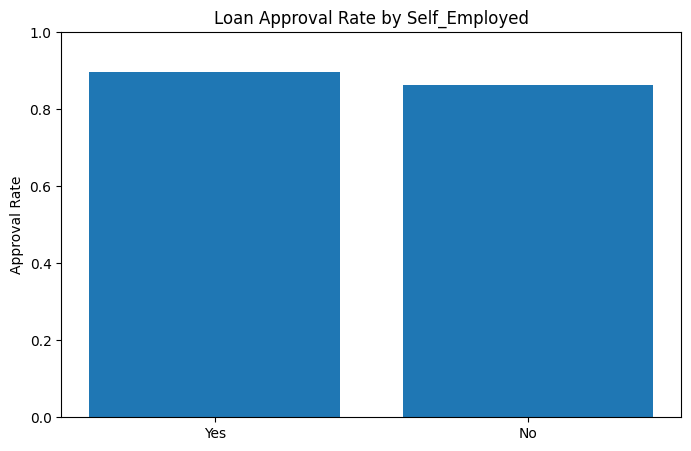

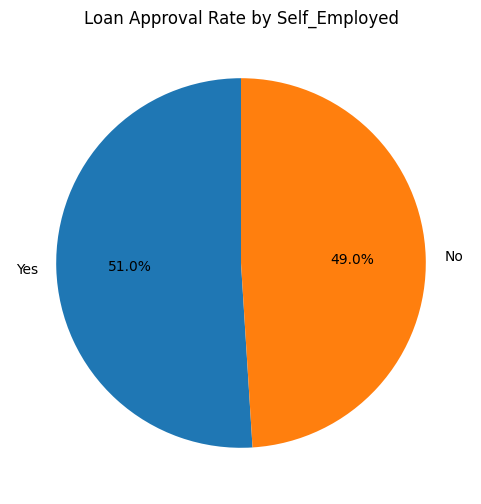

In [93]:
# 10. Analyze Loan Approval Probabilities

# Function to calculate and visualize approval rates
def analyze_approval_rate(factor, labels):
    approval_rates = []
    for label in labels:
        subset = df[df[factor] == label]
        approval_rate = subset['Loan_Status'].value_counts(normalize=True).get('Yes', 0)
        approval_rates.append(approval_rate)

    # Bar Plot
    plt.figure(figsize=(8, 5))
    plt.bar(labels, approval_rates)
    plt.title(f'Loan Approval Rate by {factor}')
    plt.ylabel('Approval Rate')
    plt.ylim(0, 1)
    plt.show()

    # Pie Chart
    plt.figure(figsize=(6, 6))
    plt.pie(approval_rates, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'Loan Approval Rate by {factor}')
    plt.show()

# i. Gender
analyze_approval_rate('Gender', ['Male', 'Female'])

# ii. Education
analyze_approval_rate('Education', ['Graduate', 'Not Graduate'])

# iii. Employment (Assuming 'Self_Employed' indicates employment status)
analyze_approval_rate('Self_Employed', ['Yes', 'No'])

Index(['Loan_ID', 'Age', 'Applicant_Income', 'Coapplicant_Income',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status',
       'Gender_Female', 'Gender_Male', 'Occupation_Business', 'Occupation_Job',
       'Married_No', 'Married_Yes', 'Past_Health_Issue_No',
       'Past_Health_Issue_Yes', 'Dependents_0', 'Dependents_1', 'Dependents_2',
       'Dependents_3', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')
                         Feature  Coefficient
4              num__Dependents_0     0.155867
2                num__Married_No    -0.069326
3               num__Married_Yes     0.069326
7    num__Education_Not Graduate     0.065311
6        num__Education_Graduate    -0.065311
15  num__Property_Area_Semiurban     0.045494
10         num__Applicant_Income    -0.042686
9         num__Self_Emplo

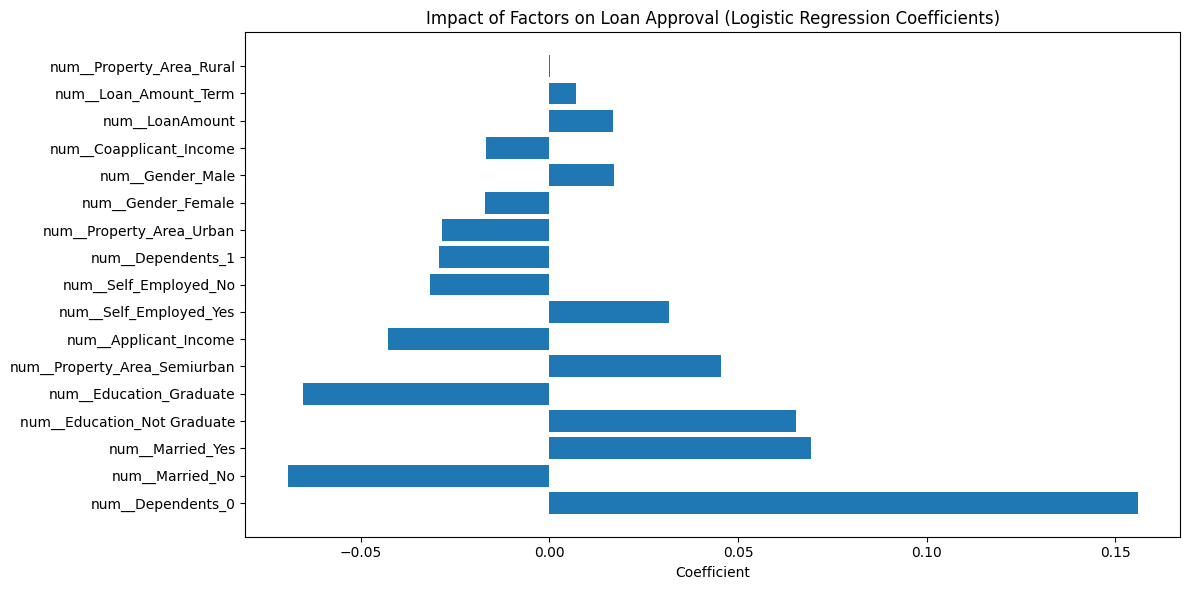

In [105]:
# Analyze Loan Approval Based on Factors

# Factors to analyze (excluding Loan_ID, Past_Health_Issue, Credit_History)
factors_to_analyze = ['Gender_Female', 'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_0', 'Dependents_1', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes'
      , 'Applicant_Income', 'Coapplicant_Income',
                     'LoanAmount', 'Loan_Amount_Term', 'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban']

# Verify the column names in your DataFrame
print(df.columns)

# Logistic Regression for analyzing factor impact
# Adjust the factors_to_analyze list based on the actual column names in your DataFrame
X = df[factors_to_analyze]
# Handle missing values in 'Loan_Status' - replace 'Y' and 'N' with appropriate values
y = df['Loan_Status'].fillna('Unknown').map({'Yes': 1, 'No': 0, 'Unknown': -1})  # Assuming 'Y' is approval, 'N' is not, and handling unknowns

# Drop rows where the target variable is unknown
X = X[y != -1]
y = y[y != -1]

# Preprocess categorical variables (One-Hot Encoding)
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
X_processed = preprocessor.fit_transform(X)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_processed, y)

# Get coefficients (represent impact of each factor)
coefficients = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

# Print coefficients
print(coefficients)

# Visualize coefficients (bar plot)
plt.figure(figsize=(12, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.title('Impact of Factors on Loan Approval (Logistic Regression Coefficients)')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()